###Подтянем зависимости

In [1]:
!pip install torchaudio==0.7.0

     |████████████████████████████████| 7.6MB 9.2MB/s 


In [2]:
!pip install -U librosa

     |████████████████████████████████| 184kB 10.1MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
  Created wheel for librosa: filename=librosa-0.8.0-cp36-none-any.whl size=201375 sha256=614b570f38309d02d3bfb1bc5fc770c2041c12e4779fed84eba1ba876e9d0faa
  Stored in directory: /root/.cache/pip/wheels/ee/10/1e/382bb4369e189938d5c02e06d10c651817da8d485bfd1647c9
Successfully built librosa
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Successfully uninstalled librosa-0.6.3


In [3]:
import cv2
import numpy as np
import pandas as pd
import time
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio

import torchvision
from torchvision import models
from torchvision import transforms

import librosa
from librosa import feature
from librosa.feature import inverse

from IPython import display as display_

from matplotlib import pyplot as plt
%pylab inline

import os
import random
import PIL

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Populating the interactive namespace from numpy and matplotlib


###Подключим логгер

In [ ]:
!pip install --upgrade wandb

Requirement already up-to-date: wandb in /usr/local/lib/python3.6/dist-packages (0.10.12)


In [ ]:
import wandb
!wandb login 32f7df3c332802b239b3a621db53985fe17d319e
wandb.init(project="the_sound_of_pixels")

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


###Подключим гугл лиск

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Конфиг

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
print(device)

cuda


In [6]:
k = 8  # кол-во фильтров
T = 3  # кол-во кадров
mels_number = 128
spec_len = 128

###Video analysis network

In [7]:
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [8]:
class modified_residual_block(nn.Module):
    def __init__(self):
        super(modified_residual_block, self).__init__()

        dilation_value = 2
        
        self.conv_0 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding=(1, 1), bias = False, dilation = dilation_value)
        self.conv_1 = nn.Conv2d(512, 512, kernel_size=(3, 3),  padding=(1, 1), bias=False, dilation = dilation_value)
        self.conv_2 = nn.Conv2d(512, 512, kernel_size=(1, 1),  bias=False, dilation = dilation_value)
        
        self.conv_layer_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3),  padding=(1, 1), bias = False, dilation = dilation_value)
        
        self.batch_norm_common = nn.modules.batchnorm.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        self.relu_activation = nn.ReLU(inplace=True)
        
        self.conv_layer_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3),  padding=(1, 1), bias = False, dilation = dilation_value)

    def forward(self, x):
        x = self.conv_0(x)
        x = self.batch_norm_common(x)
        x = self.relu_activation(x)
        
        x = self.conv_1(x)
        x = self.batch_norm_common(x)
        x = self.conv_2(x)
        x = self.batch_norm_common(x)
        
        x = self.conv_layer_1(x)
        x = self.batch_norm_common(x)
        x = self.relu_activation(x)
        x = self.conv_layer_2(x)
        
        x = self.batch_norm_common(x)
        
        return x

class ResNet_end(nn.Module):
    def __init__(self):
        super(ResNet_end, self).__init__()

        self.basic_block = modified_residual_block()
        self.last_conv_layer = nn.Conv2d(in_channels=512, out_channels=k, kernel_size=(3, 3), padding=(1, 1), bias = False)
        self.train_max_pool = nn.MaxPool3d(kernel_size=(3, 6, 6))
        self.predict_max_pool = nn.MaxPool3d(kernel_size = (3, 1, 1))
        self.sigma = nn.Sigmoid()

    def forward(self, x, predict = False):
        x = self.basic_block(x)
        x = self.last_conv_layer(x)
        if predict:
            x = self.predict_max_pool(x.transpose(0, 1))
        else:
            x = self.train_max_pool(x.transpose(0, 1))
        x = self.sigma(x)
        return x

class modified_ResNet(nn.Module):
    def __init__(self):
        super(modified_ResNet, self).__init__()

        self.main_block = torch.nn.Sequential(*(list(resnet18.children())[:-3]))
        self.end_block = ResNet_end()
    
    def forward(self, x):
        x = self.main_block(x)
        x = self.end_block(x)

        return x

###Audio analysis network

In [9]:
unet = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana')

Downloading: "https://github.com/milesial/Pytorch-UNet/archive/master.zip" to /root/.cache/torch/hub/master.zip


In [10]:
unet

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [11]:
class modified_up_conv(nn.Module):
    def __init__(self):
        super(modified_up_conv, self).__init__()
        
        self.up_layer = nn.Upsample(scale_factor=2.0, mode="bilinear")

        self.conv_layer = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x1, x2):
        x2_upsampled = self.up_layer(x2)
        # print("x6_upsampled.shape:", x2_upsampled.shape)
        x = torch.cat([x1, x2_upsampled], dim=1)
        x = self.conv_layer(x)

        return x

class modified_UNet(nn.Module):
    def __init__(self):
        super(modified_UNet, self).__init__()

        self.inc = list(unet.children())[0]
        self.down1 = list(unet.children())[1]
        self.down2 = list(unet.children())[2]
        self.down3 = list(unet.children())[3]
        # self.down4 = list(unet.children())[4]
        self.down4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Sequential(
                nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True)
            )
        )
        self.down5 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Sequential(
                nn.Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True)
            )
        )
        
        self.up0 = modified_up_conv()

        self.up1 = list(unet.children())[5]
        self.up2 = list(unet.children())[6]
        self.up3 = list(unet.children())[7]
        self.up4 = list(unet.children())[8]

        self.last_conv_layer = nn.Conv2d(
            in_channels=64,
            out_channels=k,
            kernel_size=(1, 1)
        )

    def forward(self, x):
        # print("x.shape:", x.shape)
        x1 = self.inc(x)
        # print("x1.shape:", x1.shape)
        x2 = self.down1(x1)
        # print("x2.shape:", x2.shape)
        x3 = self.down2(x2)
        # print("x3.shape:", x3.shape)
        x4 = self.down3(x3)
        # print("x4.shape:", x4.shape)
        x5 = self.down4(x4)
        # print("x5.shape:", x5.shape)
        x6 = self.down5(x5)
        # print("x6.shape:", x6.shape)

        x = self.up0(x5, x6)
        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.last_conv_layer(x)
        return logits

###Audio synthesizer network

In [12]:
class mask_network(nn.Module):
    def __init__(self):
        super(mask_network, self).__init__()

        self.layer = nn.Linear(k, 1, bias = True)
        self.activ = nn.Sigmoid()
    
    def forward(self, x):
        x = self.layer(x)

        return self.activ(x)

http://scipy.github.io/devdocs/generated/scipy.signal.istft.html#scipy.signal.istft

###Utils

In [13]:
p = transforms.Compose([transforms.Resize((224, 224))])

In [14]:
root = "/content/drive/My Drive/Dataset/Dataset"
dirlist = [item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item))]

In [15]:
dirlist = sorted(dirlist)[:-1]

In [16]:
def name_of_instr(dir_name, numb):
    begin = 0
    for i in range(numb + 1):
        begin = dir_name[begin + 1:].find('_') + begin + 1
    end = dir_name[begin + 1:].find('_') + begin + 1
    if (end == begin):
        return dir_name[begin + 1:]
    else:
        return dir_name[begin + 1:end]

In [17]:
# dirlist = sorted(dirlist)[:40]

В словаре vid_crop будут храниться части кусков, которые надо выделять в видео, чтобы посмотреть на инструмент вблизи

In [18]:
vid_crop = {}
vid_crop[dirlist[0]] = [[[0.3, 0.8], [0.5, 1]], [[0.3, 0.7], [0.1, 0.6]]]
vid_crop[dirlist[1]] = [[[0.3, 0.8], [0.5, 1]], [[0.3, 0.8], [0.2, 0.7]]]
vid_crop[dirlist[2]] = [[[0.4, 0.9], [0.3, 0.8]], [[0.4, 0.9], [0.2, 0.7]]]
vid_crop[dirlist[3]] = [[[0.3, 0.8], [0.3, 0.8]], [[0.4, 0.9], [0.1, 0.6]]]
vid_crop[dirlist[4]] = [[[0.4, 0.9], [0.3, 0.8]], [[0.4, 0.9], [0.3, 0.8]]]
#vid_crop[dirlist[7]] = [[[0.4, 0.9], [0.3, 0.8]], [[0.4, 0.9], [0.2, 0.7]]]
vid_crop[dirlist[7]] = [[[0.5, 0.8], [0.4, 0.7]], [[0.4, 0.7], [0.3, 0.6]]]
vid_crop[dirlist[8]] = [[[0.4, 0.9], [0.4, 0.9]], [[0.4, 0.9], [0.2, 0.7]]]
vid_crop[dirlist[9]] = [[[0.4, 0.9], [0.3, 0.8]], [[0.4, 1], [0.1, 0.5]]]
vid_crop[dirlist[10]] = [[[0.4, 0.9], [0.4, 0.9]], [[0.4, 1], [0.2, 0.7]]]
vid_crop[dirlist[16]] = [[[0.4, 0.9], [0.5, 1]], [[0.4, 0.9], [0.2, 0.7]], [[0.5, 1], [0.3, 0.8]]]
vid_crop[dirlist[17]] = [[[0.3, 0.8], [0.5, 1]], [[0.4, 0.9], [0.3, 0.8]], [[0.4, 0.9], [0.3, 0.8]]]
vid_crop[dirlist[18]] = [[[0.4, 0.9], [0.4, 0.9]], [[0.3, 0.8], [0.4, 0.9]], [[0.4, 1], [0.3, 0.8]]]
vid_crop[dirlist[19]] = [[[0.5, 1], [0.3, 0.8]], [[0.3, 0.8], [0.3, 0.8]], [[0.5, 1], [0.2, 0.7]]]

In [19]:
def get_spec_and_waveform(audio_name, part):
    waveform, sample_rate = torchaudio.load(audio_name)
    # spectrogram = mel_transform(waveform)
    wav_len = waveform.shape[1]
    wav_start_index = int(wav_len * part)
    wav_end_index = wav_start_index + 256 * spec_len * 2
    waveform = waveform[:,  wav_start_index:wav_end_index]
    # print("waveform.shape:", waveform.shape)
    mel_spec = librosa.feature.melspectrogram(waveform.squeeze().numpy(), 22050, n_fft=512, n_mels=mels_number)
    spectrogram = torch.log(torch.tensor(mel_spec) + 1e-9).to(device)
    # spectrogram = torch.tensor(mel_spec).to(device)
    # print(spectrogram.shape, part)
    # spec_1 = spectrogram[:, int(part * spectrogram.shape[1]):int(part * spectrogram.shape[1]) + spec_len]

    channels_1 = [spectrogram, spectrogram, spectrogram]
    input_spec = nn.utils.rnn.pad_sequence(channels_1, batch_first=True)
    input_spec.unsqueeze_(0)
    # print("input_spec.shape", input_spec.shape)

    return input_spec, waveform

In [20]:
def get_input_data(folder_name, is_test = False):
    cap = cv2.VideoCapture('/content/drive/My Drive/Dataset/Dataset/' + folder_name)
    instruments = 2
    folder_number = int(folder_name[:2])
    if folder_number > 11 and folder_number < 24:
        instruments = 3
    elif folder_number > 23 and folder_number < 38:
        instruments = 4
    elif folder_number > 37:
        instruments = 5
    numbers = [1, 2, 3, 4, 5][:instruments]
    random.shuffle(numbers)
    choosed_instruments = sorted(numbers[:2])
    #print(time.time() - a, "to choose instruments")
    #a = time.time()
    audio_name_1 = '/content/drive/My Drive/Dataset/Dataset/' + folder_name + '/AuSep_' + str(choosed_instruments[0]) + '_' + name_of_instr(folder_name, choosed_instruments[0]) + '_' + folder_name[:folder_name[4:].find('_') + 4] + '.wav'
    audio_name_2 = '/content/drive/My Drive/Dataset/Dataset/' + folder_name + '/AuSep_' + str(choosed_instruments[1]) + '_' + name_of_instr(folder_name, choosed_instruments[1]) + '_' + folder_name[:folder_name[4:].find('_') + 4] + '.wav'
    audio_mix = '/content/drive/My Drive/Dataset/Dataset/' + folder_name + '/AuMix_' + folder_name + '.wav'
    video_name = '/content/drive/My Drive/Dataset/Dataset/' + folder_name + '/Vid_' + folder_name + '.mp4'
    
    part = random.randint(3, 7) / 10
    #part = random.randint(0, 2) / 20
    # part = 0.5
    input_spec_1, waveform_1 = get_spec_and_waveform(audio_name_1, part)
    input_spec_2, waveform_2 = get_spec_and_waveform(audio_name_2, part)
    input_spec_mix, waveform_mix = get_spec_and_waveform(audio_mix, part)
    #print(time.time() - a, "to make specs")
    #a = time.time()
    cap = cv2.VideoCapture(video_name)
    frames_1 = []
    frames_2 = []
    for i in range(randint(100, 1000)):
        ret, frame = cap.read()
    for i in range(T):
        ret, frame = cap.read()
        begin_x = int((choosed_instruments[0] - 1 + vid_crop[folder_name][choosed_instruments[0] - 1][1][0]) * frame.shape[1] / instruments)
        end_x = int((choosed_instruments[0] - 1 + vid_crop[folder_name][choosed_instruments[0] - 1][1][1]) * frame.shape[1] / instruments)
        begin_y = int(frame.shape[0] * vid_crop[folder_name][choosed_instruments[0] - 1][0][0])
        end_y = int(frame.shape[0] * vid_crop[folder_name][choosed_instruments[0] - 1][0][1])
        frame_1 = np.array(p(PIL.Image.fromarray(frame[begin_y:end_y, begin_x:end_x])))
        #first_crop = frame[begin_y:end_y, begin_x:end_x]
        frames_1 += [torch.tensor(frame_1, dtype = torch.float).permute(2, 0, 1)]
        
        begin_x = int((choosed_instruments[1] - 1 + vid_crop[folder_name][choosed_instruments[1] - 1][1][0]) * frame.shape[1] / instruments)
        end_x = int((choosed_instruments[1] - 1 + vid_crop[folder_name][choosed_instruments[1] - 1][1][1]) * frame.shape[1] / instruments)
        begin_y = int(frame.shape[0] * vid_crop[folder_name][choosed_instruments[1] - 1][0][0])
        end_y = int(frame.shape[0] * vid_crop[folder_name][choosed_instruments[1] - 1][0][1])
        frame_2 = np.array(p(PIL.Image.fromarray(frame[begin_y:end_y, begin_x:end_x])))
        #second_crop = frame_2[begin_y:end_y, begin_x:end_x]
        frames_2 += [torch.tensor(frame_2, dtype = torch.float).permute(2, 0, 1)]
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    frames_1 = nn.utils.rnn.pad_sequence(frames_1, batch_first=True)
    frames_2 = nn.utils.rnn.pad_sequence(frames_2, batch_first=True)
    return input_spec_1, waveform_1,\
            input_spec_2, waveform_2,\
            input_spec_mix,\
            frames_1.to(device), frames_2.to(device)

In [21]:
def get_real_spec(folder_name):
    audio_mix = '/content/drive/My Drive/Dataset/Dataset/' + folder_name + '/AuMix_' + folder_name + '.wav'
    waveform, sample_rate = torchaudio.load(audio_mix)
    waveform = waveform.to(device)
    spectrogram = mel_transform(waveform)
    const = 4
    part = 0.5
    spec_1 = spectrogram[0, :, int(part * spectrogram.shape[2]):int(part * spectrogram.shape[2]) + const * spec_size]
    channels_1 = [spec_1, spec_1, spec_1]
    input_spec = nn.utils.rnn.pad_sequence(channels_1, batch_first=True)
    input_spec.unsqueeze_(0)
    return input_spec

In [22]:
dirlist = list(vid_crop.keys())

###Начнём тренировать сеть

####подготовим модели, оптимизаторы и функцию потерь

In [23]:
name = "Max_15_12_2020"
audio_net = torch.load('/content/drive/My Drive/' + name + '_audio_netw.pth')
video_net = torch.load('/content/drive/My Drive/' + name + '_video_netw.pth')
combine_net = torch.load('/content/drive/My Drive/' +  name + '_combine_netw.pth')
audio_net.to(device)
video_net.to(device)
combine_net.to(device)

mask_network(
  (layer): Linear(in_features=8, out_features=1, bias=True)
  (activ): Sigmoid()
)

In [ ]:
# video_net = modified_ResNet().to(device)
# audio_net = modified_UNet().to(device)
# combine_net = mask_network().to(device)

In [ ]:
video_optimizer = torch.optim.SGD(video_net.parameters(), lr=0.0001, momentum=0.9)
audio_optimizer = torch.optim.SGD(audio_net.parameters(), lr=0.0005, momentum=0.9)
masks_optimizer = torch.optim.SGD(combine_net.parameters(), lr=0.0005, momentum=0.9)

In [ ]:
wandb.watch(video_net)
wandb.watch(audio_net)
wandb.watch(combine_net)

In [ ]:
# loss_function = nn.L1Loss().to(device)
loss_function = nn.MSELoss().to(device)

####train function

In [ ]:
def train(epoch, min_error, name):
    print("--------------------------------")
    print("Epoch:", epoch + 1)
    print("--------------------------------")
    a = time.time()
    random.shuffle(dirlist)
    losses = []
    for folder_name in dirlist:
        a = time.time()
        video_optimizer.zero_grad()
        audio_optimizer.zero_grad()
        masks_optimizer.zero_grad()
        
        # print(time.time() - a, "to work with videos")
        # a = time.time()
        (input_spec_1, waveform1, input_spec_2, waveform2, input_spec_mix, frames_1, frames_2) = get_input_data(folder_name)

        #(audio_output, video_first_output, video_second_output) = main_outputs(input_spec_mix, frames_1, frames_2)
        audio_output = squeeze(audio_net(input_spec_mix))
        video_first_output = squeeze(video_net(frames_1))
        video_second_output = squeeze(video_net(frames_2))

        # print(time.time() - a, "to calculate outputs")
        # a = time.time()
        
        first_mask = torch.zeros([1, audio_output.shape[1], audio_output.shape[2]])
        for i in range(audio_output.shape[1]):
            for j in range(audio_output.shape[2]):
                input = audio_output[:, i, j] * video_first_output
                first_mask[0][i][j] = combine_net(input)
        second_mask = torch.zeros([1, audio_output.shape[1], audio_output.shape[2]])
        for i in range(audio_output.shape[1]):
            for j in range(audio_output.shape[2]):
                input = audio_output[:, i, j] * video_second_output
                second_mask[0][i][j] = combine_net(input)
        # print(time.time() - a , "before losses")
        # a = time.time()
        
        real_first_mask = torch.cat([first_mask, first_mask, first_mask]).to(device)
        real_second_mask = torch.cat([second_mask, second_mask, second_mask]).to(device)
        
        #real_spec_mix = get_real_spec(folder_name)
        first_output = real_first_mask * squeeze(input_spec_mix)
        second_output = real_second_mask * squeeze(input_spec_mix)
        output = torch.cat([first_output, second_output], dim = 1)
        truth = torch.cat([squeeze(input_spec_1), squeeze(input_spec_2)], dim = 1)
        # print(time.time() - a , "to use everything")
        
        
        loss = loss_function(output, truth)
        # print(time.time() - a, "to calculate loss")
        # a = time.time()
        loss.backward()
        # print(time.time() - a, "to use loss.backward()")
        print("loss =", loss.item())
        # wandb.log({"Train Loss": loss})
        # a = time.time()
        losses.append(loss.item())
        
        video_optimizer.step()
        audio_optimizer.step()
        masks_optimizer.step()
        
        # print(time.time() - a, "to optimize")
        print(time.time() - a, "for dir", folder_name)
    # losses = losses / len(dirlist)
    mean_loss = sum(losses) / len(losses)
    if mean_loss < min_error:
        print("Saved weights as best")
        min_error = mean_loss
        torch.save(audio_net, '/content/drive/My Drive/' + name + '_audio_netw.pth')
        torch.save(video_net, '/content/drive/My Drive/' + name + '_video_netw.pth')
        torch.save(combine_net, '/content/drive/My Drive/' +  name + '_combine_netw.pth')

    #else:
    #    torch.save(audio_end, '/content/drive/My Drive/audiow.pth')
    #    torch.save(video_end, '/content/drive/My Drive/videow.pth')
    #    torch.save(combine_net, '/content/drive/My Drive/combinew.pth')
    print("Mean loss in epoch", epoch + 1, ":", mean_loss)
    wandb.log({"Train Mean Loss": mean_loss})
    return min_error

####training

In [ ]:
dirlist = ['08_Spring_fl_vn']
vid_crop['08_Spring_fl_vn'] = [[[0.5, 0.8], [0.4, 0.7]], [[0.4, 0.7], [0.3, 0.6]]]

In [41]:
print(len(dirlist))

13


In [ ]:
min_error = 1000

for epoch in range (100):
    min_error = train(epoch, min_error, "Max_15_12_2020")

--------------------------------
Epoch: 1
--------------------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


loss = 8.431396484375
39.36289381980896 for dir 08_Spring_fl_vn
Saved weights as best
Mean loss in epoch 1 : 8.431396484375
--------------------------------
Epoch: 2
--------------------------------
loss = 7.895871162414551
35.517926931381226 for dir 08_Spring_fl_vn
Saved weights as best
Mean loss in epoch 2 : 7.895871162414551
--------------------------------
Epoch: 3
--------------------------------
loss = 7.04213809967041
29.17724299430847 for dir 08_Spring_fl_vn
Saved weights as best
Mean loss in epoch 3 : 7.04213809967041
--------------------------------
Epoch: 4
--------------------------------
loss = 7.831933498382568
34.241215467453 for dir 08_Spring_fl_vn
Mean loss in epoch 4 : 7.831933498382568
--------------------------------
Epoch: 5
--------------------------------
loss = 7.831934452056885
26.939948320388794 for dir 08_Spring_fl_vn
Mean loss in epoch 5 : 7.831934452056885
--------------------------------
Epoch: 6
--------------------------------
loss = 7.895871162414551
31

###Протестируем нашу модель

####переопределим получение мелспектрограммы - уберём логарифм

In [24]:
def get_test_spec_and_waveform(audio_name, part):
    waveform, sample_rate = torchaudio.load(audio_name)
    # spectrogram = mel_transform(waveform)
    wav_len = waveform.shape[1]
    wav_start_index = int(wav_len * part)
    wav_end_index = wav_start_index + 256 * spec_len * 2 * 4
    waveform = waveform[:,  wav_start_index:wav_end_index]
    # print("waveform.shape:", waveform.shape)
    mel_spec = librosa.feature.melspectrogram(waveform.squeeze().numpy(), 22050, n_fft=512, n_mels=mels_number)
    # spectrogram = torch.log(torch.tensor(mel_spec) + 1e-9).to(device)
    spectrogram = torch.tensor(mel_spec).to(device)
    # print(spectrogram.shape, part)
    # spec_1 = spectrogram[:, int(part * spectrogram.shape[1]):int(part * spectrogram.shape[1]) + spec_len]

    channels_1 = [spectrogram, spectrogram, spectrogram]
    input_spec = nn.utils.rnn.pad_sequence(channels_1, batch_first=True)
    input_spec.unsqueeze_(0)
    # print("input_spec.shape", input_spec.shape)

    return input_spec, waveform

In [25]:
def get_test_input_data(folder_name, is_test = False):
    cap = cv2.VideoCapture('/content/drive/My Drive/Dataset/Dataset/' + folder_name)
    instruments = 2
    folder_number = int(folder_name[:2])
    if folder_number > 11 and folder_number < 24:
        instruments = 3
    elif folder_number > 23 and folder_number < 38:
        instruments = 4
    elif folder_number > 37:
        instruments = 5
    numbers = [1, 2, 3, 4, 5][:instruments]
    random.shuffle(numbers)
    choosed_instruments = sorted(numbers[:2])
    #print(time.time() - a, "to choose instruments")
    #a = time.time()
    audio_name_1 = '/content/drive/My Drive/Dataset/Dataset/' + folder_name + '/AuSep_' + str(choosed_instruments[0]) + '_' + name_of_instr(folder_name, choosed_instruments[0]) + '_' + folder_name[:folder_name[4:].find('_') + 4] + '.wav'
    audio_name_2 = '/content/drive/My Drive/Dataset/Dataset/' + folder_name + '/AuSep_' + str(choosed_instruments[1]) + '_' + name_of_instr(folder_name, choosed_instruments[1]) + '_' + folder_name[:folder_name[4:].find('_') + 4] + '.wav'
    audio_mix = '/content/drive/My Drive/Dataset/Dataset/' + folder_name + '/AuMix_' + folder_name + '.wav'
    video_name = '/content/drive/My Drive/Dataset/Dataset/' + folder_name + '/Vid_' + folder_name + '.mp4'
    
    part = random.randint(3, 7) / 10
    #part = random.randint(0, 2) / 20
    # part = 0.5
    input_spec_1, waveform_1 = get_test_spec_and_waveform(audio_name_1, part)
    input_spec_2, waveform_2 = get_test_spec_and_waveform(audio_name_2, part)
    input_spec_mix, waveform_mix = get_test_spec_and_waveform(audio_mix, part)
    #print(time.time() - a, "to make specs")
    #a = time.time()
    cap = cv2.VideoCapture(video_name)
    frames_1 = []
    frames_2 = []
    for i in range(randint(100, 1000)):
        ret, frame = cap.read()
    for i in range(T):
        ret, frame = cap.read()
        begin_x = int((choosed_instruments[0] - 1 + vid_crop[folder_name][choosed_instruments[0] - 1][1][0]) * frame.shape[1] / instruments)
        end_x = int((choosed_instruments[0] - 1 + vid_crop[folder_name][choosed_instruments[0] - 1][1][1]) * frame.shape[1] / instruments)
        begin_y = int(frame.shape[0] * vid_crop[folder_name][choosed_instruments[0] - 1][0][0])
        end_y = int(frame.shape[0] * vid_crop[folder_name][choosed_instruments[0] - 1][0][1])
        frame_1 = np.array(p(PIL.Image.fromarray(frame[begin_y:end_y, begin_x:end_x])))
        #first_crop = frame[begin_y:end_y, begin_x:end_x]
        frames_1 += [torch.tensor(frame_1, dtype = torch.float).permute(2, 0, 1)]
        
        begin_x = int((choosed_instruments[1] - 1 + vid_crop[folder_name][choosed_instruments[1] - 1][1][0]) * frame.shape[1] / instruments)
        end_x = int((choosed_instruments[1] - 1 + vid_crop[folder_name][choosed_instruments[1] - 1][1][1]) * frame.shape[1] / instruments)
        begin_y = int(frame.shape[0] * vid_crop[folder_name][choosed_instruments[1] - 1][0][0])
        end_y = int(frame.shape[0] * vid_crop[folder_name][choosed_instruments[1] - 1][0][1])
        frame_2 = np.array(p(PIL.Image.fromarray(frame[begin_y:end_y, begin_x:end_x])))
        #second_crop = frame_2[begin_y:end_y, begin_x:end_x]
        frames_2 += [torch.tensor(frame_2, dtype = torch.float).permute(2, 0, 1)]
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    frames_1 = nn.utils.rnn.pad_sequence(frames_1, batch_first=True)
    frames_2 = nn.utils.rnn.pad_sequence(frames_2, batch_first=True)
    return input_spec_1, waveform_1,\
            input_spec_2, waveform_2,\
            input_spec_mix,\
            frames_1.to(device), frames_2.to(device)

####test function

In [32]:
def test():
    for folder_name in dirlist:
        
        (input_spec_1, waveform1, input_spec_2, waveform2, input_spec_mix, frames_1, frames_2) = get_test_input_data(folder_name)

        #(audio_output, video_first_output, video_second_output) = main_outputs(input_spec_mix, frames_1, frames_2)
        audio_output = squeeze(audio_net(input_spec_mix))
        video_first_output = squeeze(video_net(frames_1))
        video_second_output = squeeze(video_net(frames_2))

        first_mask = torch.zeros([1, audio_output.shape[1], audio_output.shape[2]])
        for i in range(audio_output.shape[1]):
            for j in range(audio_output.shape[2]):
                input = audio_output[:, i, j] * video_first_output
                first_mask[0][i][j] = combine_net(input)
        second_mask = torch.zeros([1, audio_output.shape[1], audio_output.shape[2]])
        for i in range(audio_output.shape[1]):
            for j in range(audio_output.shape[2]):
                input = audio_output[:, i, j] * video_second_output
                second_mask[0][i][j] = combine_net(input)
        # print(time.time() - a , "before losses")
        # a = time.time()
        
        real_first_mask = torch.cat([first_mask, first_mask, first_mask]).to(device)
        real_second_mask = torch.cat([second_mask, second_mask, second_mask]).to(device)
        
        #real_spec_mix = get_real_spec(folder_name)
        first_output = real_first_mask * squeeze(input_spec_mix)
        second_output = real_second_mask * squeeze(input_spec_mix)
        output = torch.cat([first_output, second_output], dim = 1)
        truth = torch.cat([squeeze(input_spec_1), squeeze(input_spec_2)], dim = 1)
        # print(time.time() - a , "to use everything")

        return input_spec_1, first_output, input_spec_2, second_output

####test

In [33]:
input_spec_1, first_output, input_spec_2, second_output = test()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [34]:
input_spec_1.cpu()
first_output.cpu()
input_spec_2.cpu()
second_output.cpu()

tensor([[[3.9308e-02, 1.6038e-02, 6.6994e-02,  ..., 5.8412e-02,
          1.3739e-01, 8.7722e-02],
         [7.9688e-02, 3.2517e-02, 1.3581e-01,  ..., 1.1841e-01,
          2.7850e-01, 1.7783e-01],
         [4.6122e-02, 1.3298e-02, 1.1716e-01,  ..., 3.1460e-01,
          2.5378e-01, 8.3831e-02],
         ...,
         [2.4494e-08, 2.3599e-14, 1.4077e-14,  ..., 4.0706e-14,
          2.7680e-14, 9.4037e-08],
         [2.3956e-08, 6.5283e-14, 2.6092e-14,  ..., 3.5359e-14,
          3.3834e-14, 9.1593e-08],
         [2.3559e-08, 4.8342e-14, 3.7178e-14,  ..., 2.7362e-14,
          3.0216e-14, 8.9932e-08]],

        [[3.9308e-02, 1.6038e-02, 6.6994e-02,  ..., 5.8412e-02,
          1.3739e-01, 8.7722e-02],
         [7.9688e-02, 3.2517e-02, 1.3581e-01,  ..., 1.1841e-01,
          2.7850e-01, 1.7783e-01],
         [4.6122e-02, 1.3298e-02, 1.1716e-01,  ..., 3.1460e-01,
          2.5378e-01, 8.3831e-02],
         ...,
         [2.4494e-08, 2.3599e-14, 1.4077e-14,  ..., 4.0706e-14,
          2.768

In [35]:
def viz(wav):
    figsize(20, 5)
    plot(wav)
    plt.show()
    display_.display(display_.Audio(wav, rate=22050))

In [ ]:
first_output.unsqueeze_(0)
second_output.unsqueeze_(0)

In [ ]:

print("input_spec_1.shape:", input_spec_1.shape)
print("first_output.shape:", first_output.shape)
print("input_spec_2.shape:", input_spec_2.shape)
print("second_output.shape:", second_output.shape)

input_spec_1.shape: torch.Size([1, 3, 128, 513])
first_output.shape: torch.Size([1, 3, 128, 513])
input_spec_2.shape: torch.Size([1, 3, 128, 513])
second_output.shape: torch.Size([1, 3, 128, 513])


input_spec_1.shape: torch.Size([1, 3, 128, 513])
stft_recovered1.shape: (513, 513)
wav_recovered1.shape: (131072,)


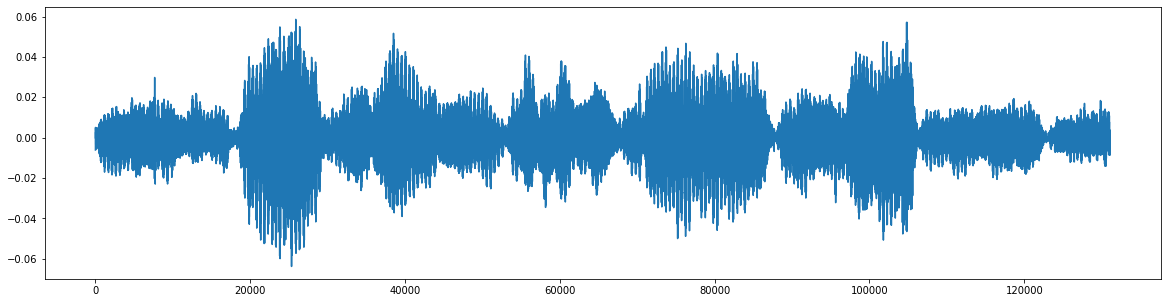

In [37]:
# input_spec_1 = nn.utils.rnn.pad_sequence([mel_spec1, mel_spec1, mel_spec1], batch_first=True).unsqueeze_(0)
print("input_spec_1.shape:", input_spec_1.shape)
stft_recovered1 = feature.inverse.mel_to_stft((input_spec_1.cpu())[0][0].detach().numpy(), sr=22050, n_fft=1024)
print("stft_recovered1.shape:", stft_recovered1.shape)
wav_recovered1 = librosa.griffinlim(stft_recovered1, n_iter=64, hop_length=256)
print("wav_recovered1.shape:", wav_recovered1.shape)
viz(wav_recovered1)

first_output.shape: torch.Size([1, 3, 128, 513])
stft_recovered1.shape: (513, 513)
wav_recovered1.shape: (131072,)


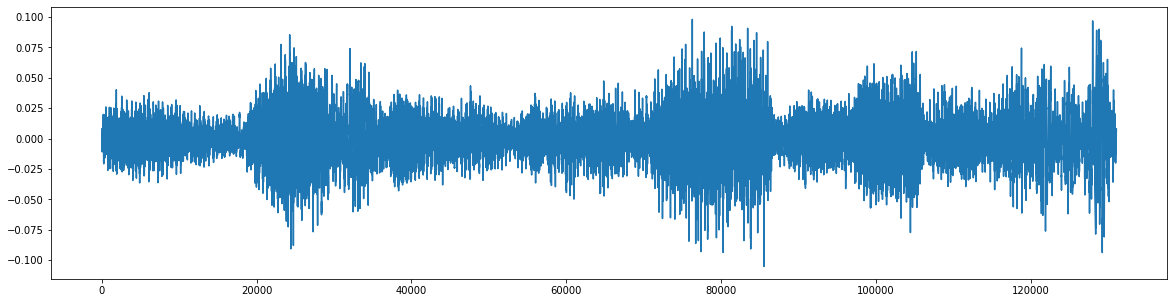

In [38]:
# input_spec_1 = nn.utils.rnn.pad_sequence([mel_spec1, mel_spec1, mel_spec1], batch_first=True).unsqueeze_(0)
print("first_output.shape:", first_output.shape)
stft_recovered_output1 = feature.inverse.mel_to_stft((first_output.cpu())[0][0].detach().numpy(), sr=22050, n_fft=1024)
print("stft_recovered1.shape:", stft_recovered_output1.shape)
wav_recovered_output1 = librosa.griffinlim(stft_recovered_output1, n_iter=64, hop_length=256)
print("wav_recovered1.shape:", wav_recovered_output1.shape)
viz(wav_recovered_output1)

input_spec_2.shape: torch.Size([1, 3, 128, 513])
stft_recovered2.shape: (513, 513)
wav_recovered2.shape: (131072,)


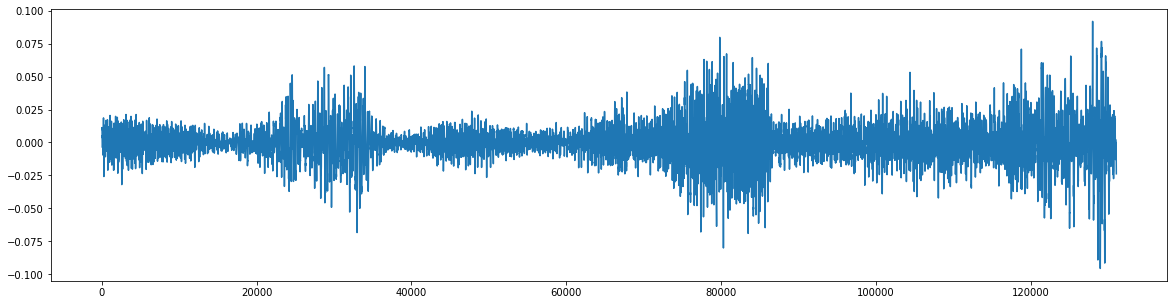

In [40]:
# input_spec_1 = nn.utils.rnn.pad_sequence([mel_spec1, mel_spec1, mel_spec1], batch_first=True).unsqueeze_(0)
print("input_spec_2.shape:", input_spec_2.shape)
stft_recovered2 = feature.inverse.mel_to_stft((input_spec_2.cpu())[0][0].detach().numpy(), sr=22050, n_fft=1024)
print("stft_recovered2.shape:", stft_recovered2.shape)
wav_recovered2 = librosa.griffinlim(stft_recovered2, n_iter=64, hop_length=256)
print("wav_recovered2.shape:", wav_recovered2.shape)
viz(wav_recovered2)

first_output.shape: torch.Size([1, 3, 128, 513])
stft_recovered1.shape: (513, 513)
wav_recovered1.shape: (131072,)


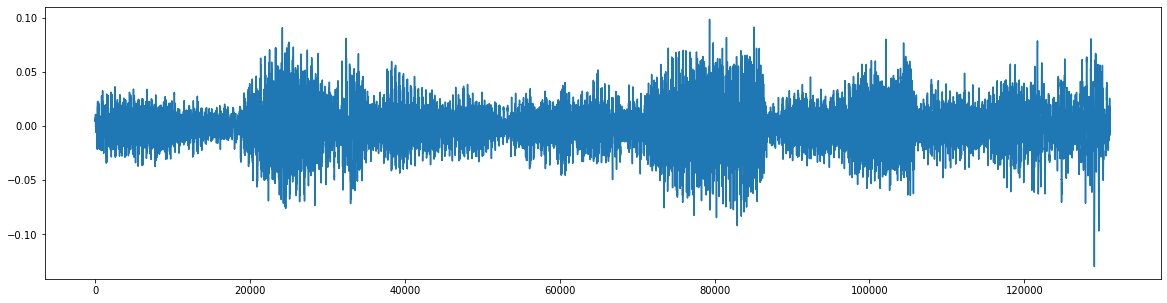

In [39]:
# input_spec_1 = nn.utils.rnn.pad_sequence([mel_spec1, mel_spec1, mel_spec1], batch_first=True).unsqueeze_(0)
print("first_output.shape:", second_output.shape)
stft_recovered_output1 = feature.inverse.mel_to_stft((second_output.cpu())[0][0].detach().numpy(), sr=22050, n_fft=1024)
print("stft_recovered1.shape:", stft_recovered_output1.shape)
wav_recovered_output1 = librosa.griffinlim(stft_recovered_output1, n_iter=64, hop_length=256)
print("wav_recovered1.shape:", wav_recovered_output1.shape)
viz(wav_recovered_output1)

In [ ]:
w1 = waveform1
t_w1 = test_waveform1

In [ ]:
waveform1 = waveform1.cpu()
test_waveform1 = test_waveform1.cpu()

In [ ]:
def viz(wav):
    figsize(20, 5)
    plot(wav)
    plt.show()
    display_.display(display_.Audio(wav, rate=22050))

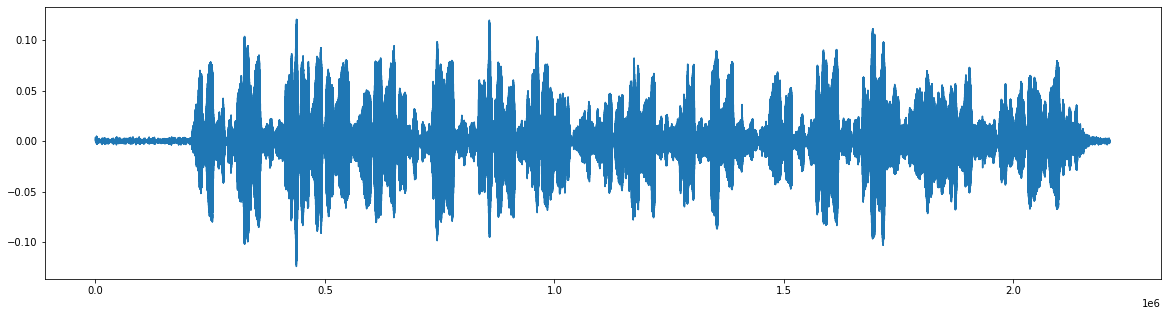

In [ ]:
waveform1.squeeze_().detach().numpy()
viz(waveform1)

In [ ]:
test_waveform1.squeeze_()
test_waveform1 = test_waveform1.detach().numpy()

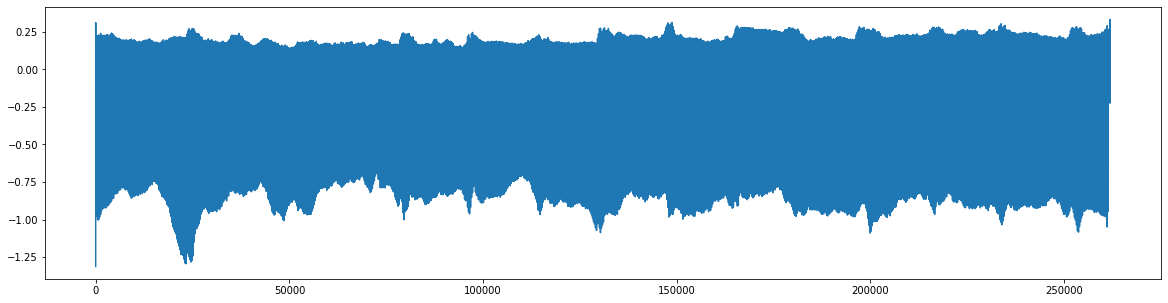

In [ ]:
viz(test_waveform1)

In [ ]:
torch.istft(input: torch.Tensor, n_fft: int,
            hop_length: Optional[int] = None,
            win_length: Optional[int] = None,
            window: Optional[torch.Tensor] = None,
            center: bool = True,
            normalized: bool = False,
            onesided: Optional[bool] = None,
            length: Optional[int] = None
            return_complex: bool = False) → torch.Tensor

In [ ]:
#min_error = 1000

for epoch in range (8, 10):
    min_error = train(epoch, min_error)

--------------------------------
Epoch: 9
--------------------------------
loss = 1.5438508987426758
20.80195426940918 for dir 05_Entertainer_tpt_tpt
loss = 2.431018114089966
24.73024296760559 for dir 18_Nocturne_vn_fl_tpt
loss = 1.6269032955169678
21.307376623153687 for dir 10_March_tpt_sax
loss = 2.641855239868164
24.41431498527527 for dir 20_Pavane_tpt_vn_vc
loss = 2.1012070178985596
23.895702362060547 for dir 17_Nocturne_vn_fl_cl
loss = 1.7695322036743164
20.524842739105225 for dir 11_Maria_ob_vc
loss = 2.3316431045532227
24.724719524383545 for dir 19_Pavane_cl_vn_vc
loss = 1.6916688680648804
20.297683000564575 for dir 01_Jupiter_vn_vc
loss = 1.7468303442001343
21.916991472244263 for dir 02_Sonata_vn_vn
loss = 1.999107837677002
18.471635818481445 for dir 03_Dance_fl_cl
loss = 1.6756891012191772
22.34286093711853 for dir 08_Spring_fl_vn
loss = 1.9166038036346436
18.898632526397705 for dir 04_Allegro_fl_fl
loss = 2.2989089488983154
20.8964786529541 for dir 09_Jesus_tpt_vn
Mean loss i

In [ ]:
# divided learning rate by 2 after 6th epoch
mean_losses = [5.221943085010235, 4.3706739865816555, 2.933400740990272, 2.3886164243404684, 1.953327591602619, 2.004491164134099, 1.9901581910940318, 2.151312525455768,  1.9826783675413866, 1.9116770854363074]

In [ ]:
best_directories = ['04_Allegro_fl_fl', '03_Dance_fl_cl', '10_March_tpt_sax', '01_Jupiter_vn_vc', '11_Maria_ob_vc', '02_Sonata_vn_vn']
dirlist = best_directories

In [ ]:
new_losses = [1.7471404671669006, 1.6302514870961506, 1.6533418695131938, 1.7158955732981365, 1.6540089845657349, 1.6722270846366882, 1.5661984086036682, 1.7098039587338765]

In [ ]:
dirlist = ['03_Dance_fl_cl', '04_Allegro_fl_fl']